# PyTorch recurrent neural networks

This notebook demosntrates the three most common types of recurrent neural networks. 
Namely, we focus on: 
    Simple recurrent neural network   (RNN) 
    Gated recurrent units             (GRU)
    Long short term memory netowrk    (LSTM) 

The models are nicely demonstrated and explained in the following post:  
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

The models are trained on a one dimensional time series of a noisy sin-wave. 


In [1]:
# load packages and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
%matplotlib inline
from torch import nn
from torch.autograd import Variable

In [ ]:
use_gpu=torch.cuda.is_available()
print("GPU is available: " use_gpu)


In [3]:
# Parameters
look_back=200        # historic time window
look_forward=1        # prediction time horizont
hidden_size=100       # dimension of hidden variable h
num_layer=3          # number of LSTM layers
dropout=   0.3      # dropout rate after each LSTM layer

epochs=1000

sample_size=500

In [24]:
# generate data (noisy sin waves)

def sine_2(X, signal_freq=60.):

    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

def sample(sample_size=sample_size):
    random_offset = np.random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine_2(X + random_offset)).astype('float32')
    return Y

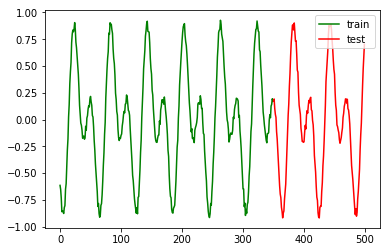

In [25]:
dataset=sample()
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

plt.plot(np.arange(train_size), dataset[:train_size], 'g', label="train") 
plt.plot(np.arange(train_size,len(dataset)), dataset[train_size:], 'r', label='test')
plt.legend()
plt.show()

In [26]:
# Normalize data to [0, 1]

max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))


In [27]:
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- look_forward):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back:(i + look_back+look_forward)])
    return np.array(dataX), np.array(dataY)

In [28]:

data_X, data_Y = create_dataset(dataset, look_back, look_forward)


In [29]:
# Slit data to train and test data
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [34]:
# Convert numpy array to PyTorch tensor
train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, look_forward)
test_X = test_X.reshape(-1, 1, look_back)
test_Y = test_Y.reshape(-1, 1, look_forward)

train_x = torch.from_numpy(train_X).cuda()
train_y = torch.from_numpy(train_Y).cuda()
test_x = torch.from_numpy(test_X).cuda()
test_y = torch.from_numpy(test_Y).cuda()

print(train_x.size())
print(train_y.size())
print(test_x.size())
print(test_y.size())

torch.Size([299, 1, 200])
torch.Size([299, 1, 1])
torch.Size([0])
torch.Size([0])


In [35]:
# Neural netowrk 

class model(nn.Module):
    def __init__(self, module, input_size, hidden_size, output_size, num_layers=num_layer, dropout=dropout):
        if module=="LSTM":
            super(model, self).__init__()    
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 

        elif module=="RNN":
            super(model, self).__init__()    
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        elif module=="GRU":
            super(model, self).__init__()    
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        else:
            print("No valid model")
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    
    def predict(self, inp, input_size, future=0):
        outputs=[]
        for i in range(future):# if we should predict the future
            x, _ = self.rnn(inp) # (seq, batch, hidden)
            s, b, h = x.shape
            x = x.view(s*b, h)
            x = self.reg(x)
            x = x.view(s, b, -1)
            outputs += [x]
            inp[:,:,:(input_size-1)]=inp[:,:,1:]
            inp[:,:,-1]=x.item()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [36]:
# initialize neural nets
net={}
models=['LSTM', 'RNN', 'GRU']
optimizer={}
for name in models:
    net[name]=model(name, look_back, hidden_size, look_forward).cuda()
    optimizer[name] = torch.optim.Adam(net[name].parameters(), lr=1e-2)

criterion = nn.MSELoss()
print(net)


{'LSTM': model(
  (rnn): LSTM(200, 100, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=100, out_features=1, bias=True)
), 'RNN': model(
  (rnn): RNN(200, 100, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=100, out_features=1, bias=True)
), 'GRU': model(
  (rnn): GRU(200, 100, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=100, out_features=1, bias=True)
)}


In [ ]:
# training 

for e in range(epochs):
    if (e) % 100 == 0: 
        print('-'* 20 + ' Epoch {} - {:.2f}% '.format(e, e/epochs*100) +'-'*20)
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    for name in models:
        out = net[name](var_x)
        loss = criterion(out, var_y)
        optimizer[name].zero_grad()
        loss.backward()
        optimizer[name].step()
        if (e) % 100 == 0: 
            print('{}: Loss: {:.5f}'.format(name, loss.item()))
           


-------------------- Epoch 0 - 0.00% --------------------
LSTM: Loss: 0.00124
RNN: Loss: 0.00576
GRU: Loss: 0.00217
-------------------- Epoch 100 - 10.00% --------------------
LSTM: Loss: 0.00076
RNN: Loss: 0.00346
GRU: Loss: 0.00122
-------------------- Epoch 200 - 20.00% --------------------
LSTM: Loss: 0.00061
RNN: Loss: 0.00328
GRU: Loss: 0.00100
-------------------- Epoch 300 - 30.00% --------------------
LSTM: Loss: 0.00055
RNN: Loss: 0.00273
GRU: Loss: 0.00138
-------------------- Epoch 400 - 40.00% --------------------
LSTM: Loss: 0.00038
RNN: Loss: 0.00226
GRU: Loss: 0.00104
-------------------- Epoch 500 - 50.00% --------------------
LSTM: Loss: 0.00048
RNN: Loss: 0.00161
GRU: Loss: 0.00082


In [18]:
for name in models:
    net[name] = net[name].eval() 

In [19]:
test={}
test_x=Variable(test_x)
for name in models: 
    test[name] = net[name](test_x)
    loss = criterion(test[name], test_y)
    print('{}: Loss: {:.5f}'.format(name, loss.item()))


RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:

for name in models:
    plt.plot( test[name].view(-1).data.cpu().numpy(), label=name)
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

#### 